In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from collections import Counter
import umap
import networkx as nx
from itertools import permutations 
import hdbscan
from numpy import random
import copy 

import statistics
from pylab import rcParams
from random import sample

In [50]:
class data_generator():
    def __init__(self, 
                 voters_per_cluster, 
                 votes_per_project, 
                 cluster_independence=3, 
                 spread_of_approvals=1.5, 
                 adcavpd=0.0, 
                 sdcavpd=0.1,
                 noise=0.01):
        self.voters_per_cluster = np.array(sorted(voters_per_cluster, reverse=True))
        self.votes_per_project = np.array(votes_per_project)
        self.cluster_independence = cluster_independence
        self.spread_of_approvals = spread_of_approvals
        self.avg_diff_cluster_all_voters_project_dist = adcavpd
        self.std_diff_cluster_all_voters_project_dist = sdcavpd
        self.noise = noise

        self.n_projects = len(votes_per_project)
        self.max_voters_per_cluster = max(voters_per_cluster)
        self.n_clusters = len(self.voters_per_cluster)
        self.rng = random.default_rng()
    
    @property
    def size_none_empty_projects(self):
        return len(self.none_empty_projects)
    
    @property
    def none_empty_projects(self):
        return np.where(self.votes_per_project != 0)[0]

    @property
    def votes_per_project_dist(self):
        return self.votes_per_project / sum(self.votes_per_project)
        
    @property
    def avg_approvals_per_voter(self):
        return sum(self.votes_per_project) / sum(self.voters_per_cluster)

    def convert_ballot_to_one_hot(self, ballots):
        new_ballots = np.zeros((len(ballots), self.n_projects))
        for i, vote in enumerate(ballots):
            new_ballots[i,vote] = 1
        return new_ballots
    
    def make_clusters(self):
        clusters = []
        for cluster_size in self.voters_per_cluster:
            print(self.avg_approvals_per_voter)
#             print(self.votes_per_project)

#             print(self.votes_per_project_dist)
            npic = self.n_projects_in_cluster(cluster_size)
            print(npic)
            ps = self.generate_project_set(npic)
#             print(ps)
            apv = self.approvals_per_voter(npic, cluster_size)
#             print(apv)
            cpd = self.gen_cluster_project_dist(ps)
#             print(cpd)
            cpdn,psn = self.gen_cluster_project_dist_noise(cpd, ps)
#             print(cpdn)
            ballots = self.gen_cluster_ballot(psn, apv, cpdn)
               
            # update generator
            for proj, votes in Counter([y for x in ballots for y in x]).items():
                self.votes_per_project[proj] = np.maximum(self.votes_per_project[proj] - votes, 0)
            self.voters_per_cluster = np.delete(self.voters_per_cluster, 0)
                
            ballots = self.convert_ballot_to_one_hot(ballots)
            clusters.append(ballots)
            
        return clusters
    
    def n_projects_in_cluster(self, cluster_size):
        # the lower cluster_independence is the more dependent the number of projects are in therms of clustersize. 
        return int(np.clip(random.normal(self.size_none_empty_projects * (cluster_size / self.max_voters_per_cluster), self.cluster_independence, 1), 1, self.size_none_empty_projects))
 
    def generate_project_set(self, n_projects_in_cluster):
        return self.rng.choice(self.n_projects, n_projects_in_cluster, p=self.votes_per_project_dist, replace=False, shuffle=False)
        
    def approvals_per_voter(self, n_projects_in_cluster, cluster_size):
        # spread_of_approvals determines the spread of approvals per voter within a cluster.
        return np.clip(random.normal(self.avg_approvals_per_voter + 1, self.spread_of_approvals, cluster_size), 1, max(n_projects_in_cluster, 2)).astype(int)

    def gen_cluster_project_dist(self, project_set):
        # distribution for all projects (small values for non-cluster-projects)
        new_dist = np.maximum(self.votes_per_project_dist[project_set] + random.normal(self.avg_diff_cluster_all_voters_project_dist, self.std_diff_cluster_all_voters_project_dist, len(project_set)), self.noise)
        return new_dist / sum(new_dist)
    
    def gen_cluster_project_dist_noise(self, cluster_project_dist, project_set):
        noise_projects = list(set(range(self.n_projects)) - set(project_set))
        cpdn = np.array(list(cluster_project_dist) + list(np.clip(random.gamma(self.noise, 4, len(noise_projects)), 0, 3*self.noise)))
        return cpdn / sum(cpdn), list(project_set) + noise_projects
    
    def gen_cluster_ballot(self, project_set, approvals_per_voter, cluster_project_dist):
        return [self.rng.choice(project_set, apv, p=cluster_project_dist, replace=False, shuffle=False) for apv in approvals_per_voter]
 
    def __call__(self):
        return self.make_clusters()

In [52]:
# settings for 10-15 projects
VOTERS_PER_CLUSTER = list(range(1300, 100, -100))
VOTES_PER_PROJECT = list(range(5000, 1500, -300))
old_clusters = data_generator(VOTERS_PER_CLUSTER, VOTES_PER_PROJECT, cluster_independence=3, spread_of_approvals=1.5, sdcavpd=0.1, noise=0.01)()

# settings for 40-50 projects
# VOTERS_PER_CLUSTER = list(range(250, 10, -10))
# VOTES_PER_PROJECT = list(range(600, 150, -10))
# old_clusters = data_generator(VOTERS_PER_CLUSTER, VOTES_PER_PROJECT, cluster_independence=10, spread_of_approvals=1.5, sdcavpd=0.15, noise=0.01)()

print(Counter([z for x in old_clusters for y in x for z in np.where(y==1)[0]]))

old_labels = [y for i,x in enumerate(old_clusters) for y in [i] * len(x)]
data = np.array([y for x in old_clusters for y in  x])

4.466666666666667
10
4.366103896103896
9
4.273692307692308
12
4.21037037037037
7
4.1125
10
3.97
4
4.0777777777777775
5
4.176
5
4.362857142857143
4
4.84
3
6.336
7
6.545
1
Counter({0: 5260, 1: 4720, 2: 4338, 3: 4005, 4: 3629, 5: 3607, 6: 3241, 7: 2885, 8: 2584, 10: 2245, 11: 1959, 9: 1643})


In [53]:
reducer = umap.UMAP(n_components=4, n_neighbors=100, metric='manhattan')
reducer.fit(data)
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(9000, 4)

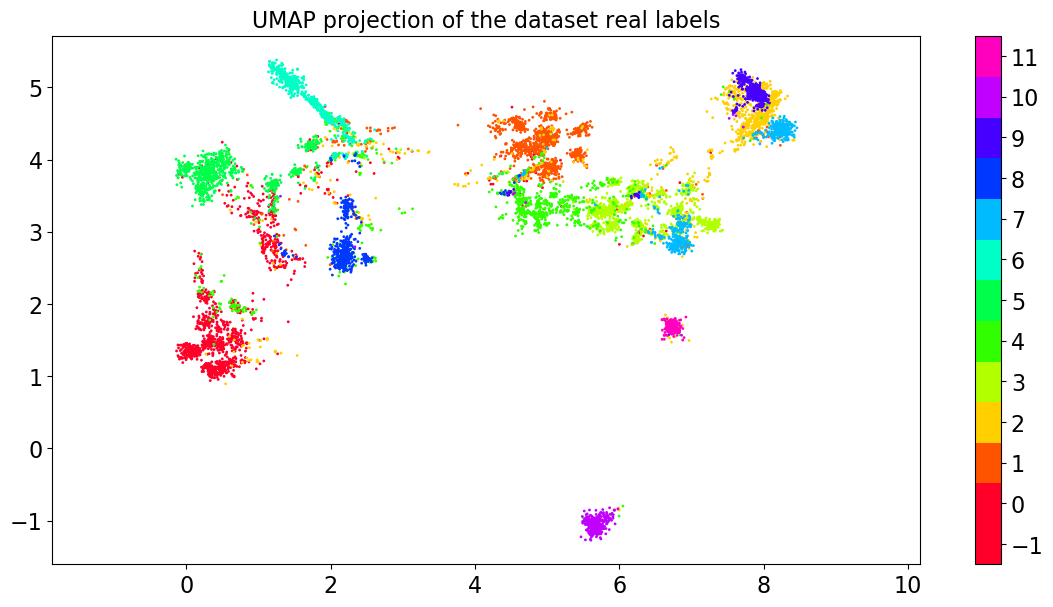

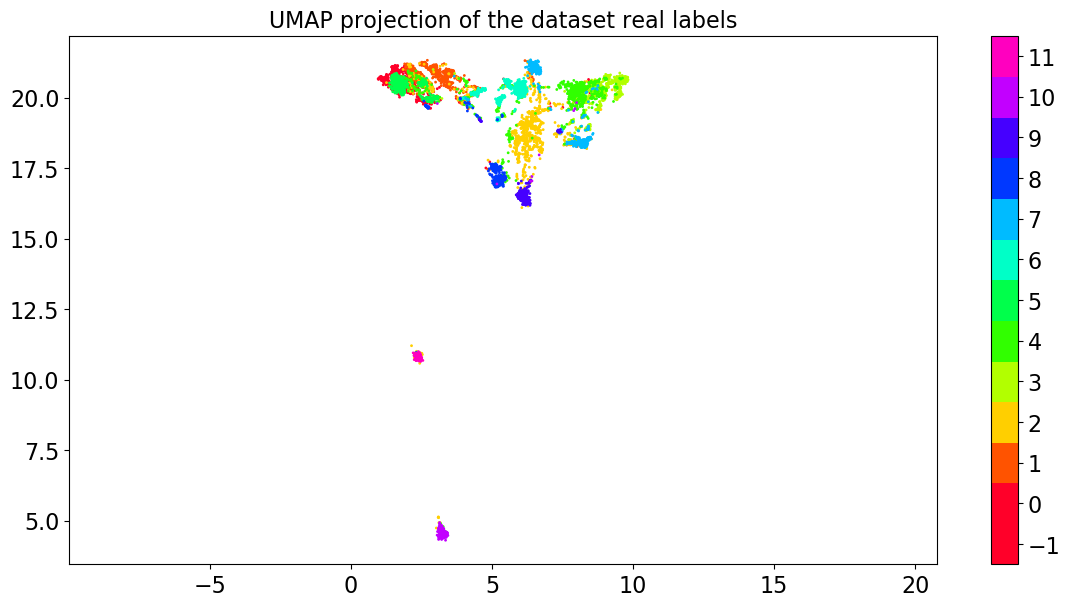

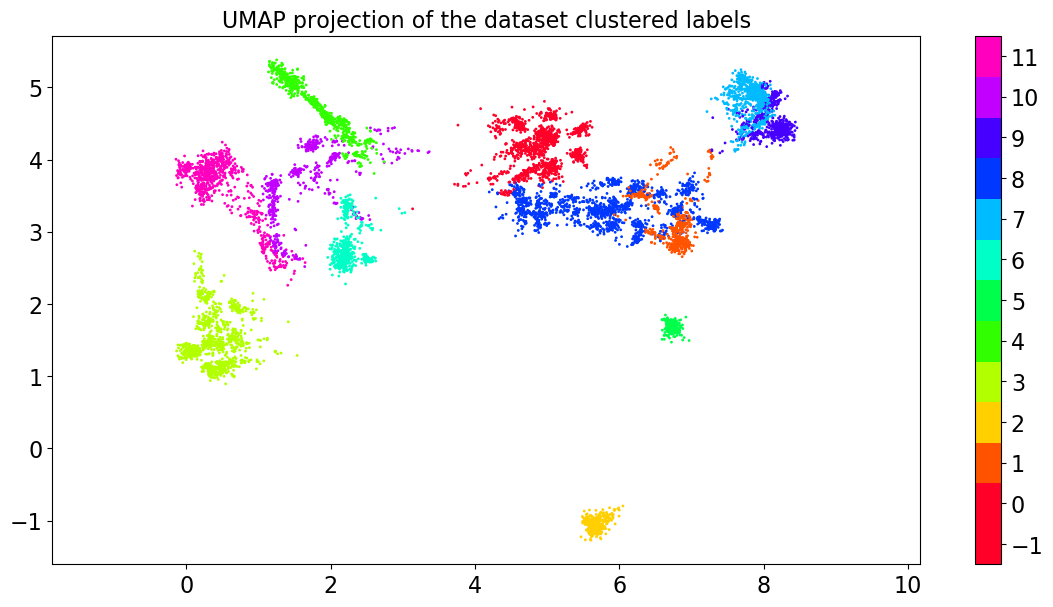

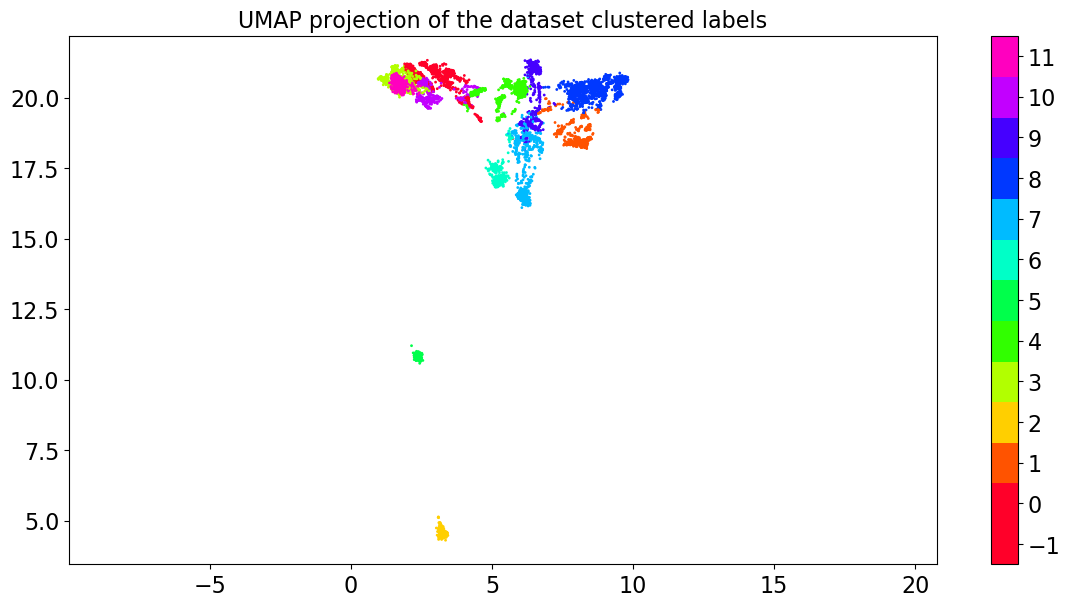

In [54]:
# n_clusters = len(old_clusters)
# k = KMeans(n_clusters).fit(embedding)

n_clusters = len(old_clusters)
k = GaussianMixture(n_clusters).fit(embedding)
k.labels_ = k.predict(embedding)

# k = DBSCAN(0.3).fit(embedding)
# n_clusters = max(k.labels_) + 1

# k = hdbscan.HDBSCAN(min_cluster_size=len(data)//100, gen_min_span_tree=True).fit(embedding)
# n_clusters = max(k.labels_) + 1

# # Visualization of HDBSCAN
# import seaborn as sns
# k.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=10,
#                                       edge_linewidth=1)
# plt.show()

# k.condensed_tree_.plot()
# plt.show()

# k.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.show()

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=old_labels, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset real labels', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=old_labels, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset real labels', fontsize=16)
    plt.show()

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
# plt.scatter(embedding[:, 0], embedding[:, 1], c=old_labels, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset clustered labels', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=k.labels_, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset clustered labels', fontsize=16)

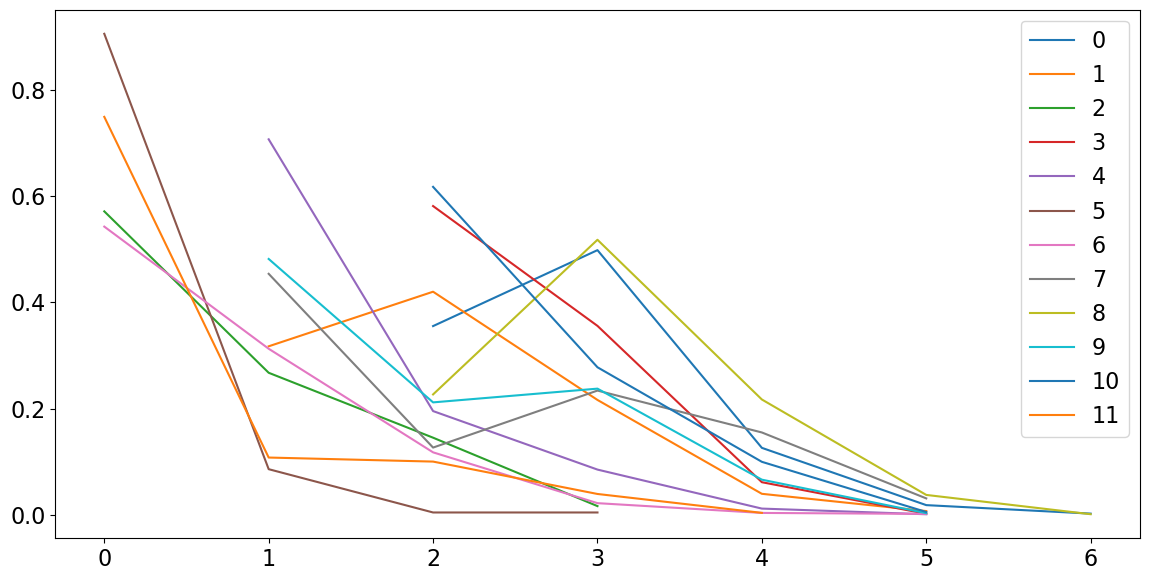

In [55]:
# print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")
cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(-1,n_clusters)}
cluster_centers_ = [np.mean(data[k.labels_ == i],0) for i in range(n_clusters)]
for c, ballot in zip(k.labels_, data):
    dis = int(np.abs(ballot - cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

0
{0: 0.7063048683160414, 1: 0.7725458898643256, 2: 0.3766959297685555, 3: 0.9162011173184358, 4: 0.16839584996009577, 5: 0.011971268954509178, 6: 0.1819632881085395, 7: 0.3160415003990423, 8: 0.028731045490822026, 9: 0.028731045490822026, 10: 0.4533120510774142, 11: 0.8140462889066241}
1253


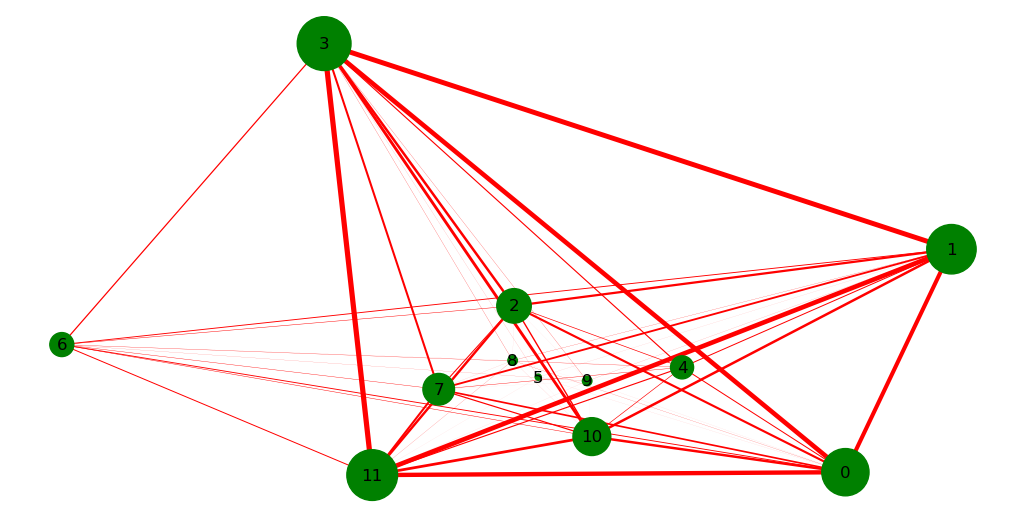

1
{0: 0.08828828828828829, 1: 0.5855855855855856, 2: 0.08468468468468468, 3: 0.7225225225225225, 4: 0.9009009009009009, 5: 0.11891891891891893, 6: 0.055855855855855854, 7: 0.6828828828828829, 8: 0.023423423423423424, 9: 0.023423423423423424, 10: 0.14774774774774774, 11: 0.025225225225225224}
555


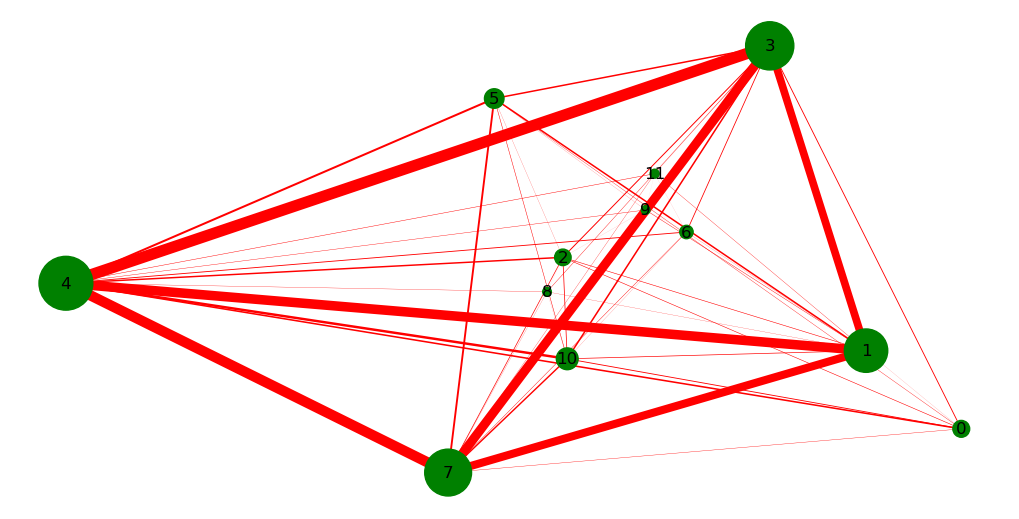

2
{0: 0.006600660066006601, 1: 0.0033003300330033004, 2: 0.8877887788778878, 3: 0.0, 4: 0.7854785478547854, 5: 0.9900990099009901, 6: 0.858085808580858, 7: 0.8877887788778878, 8: 0.9306930693069307, 9: 0.9966996699669967, 10: 0.0, 11: 0.0}
303


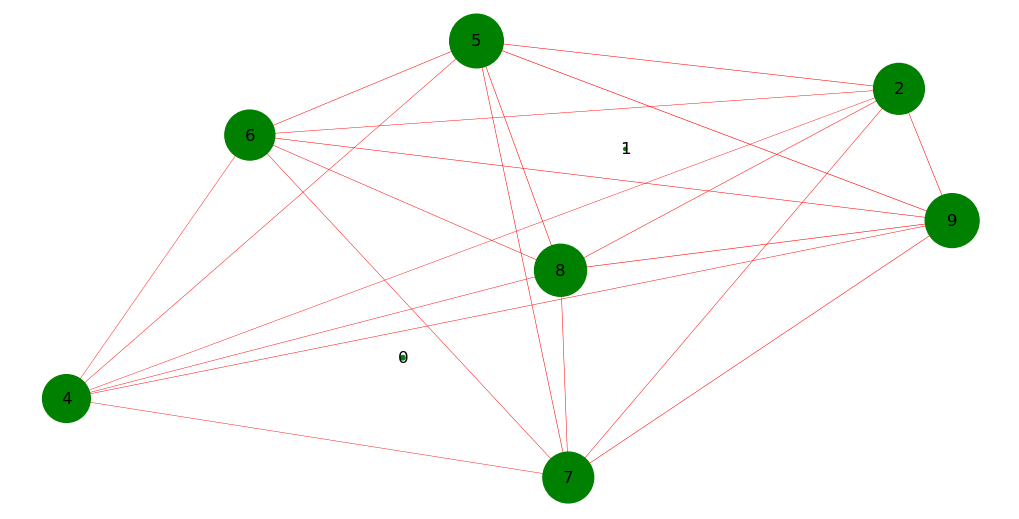

3
{0: 0.6700819672131147, 1: 0.7182377049180327, 2: 0.701844262295082, 3: 0.3155737704918033, 4: 0.07172131147540983, 5: 0.9907786885245902, 6: 0.8790983606557377, 7: 0.29508196721311475, 8: 0.006147540983606557, 9: 0.0020491803278688526, 10: 0.7530737704918032, 11: 0.06557377049180328}
976


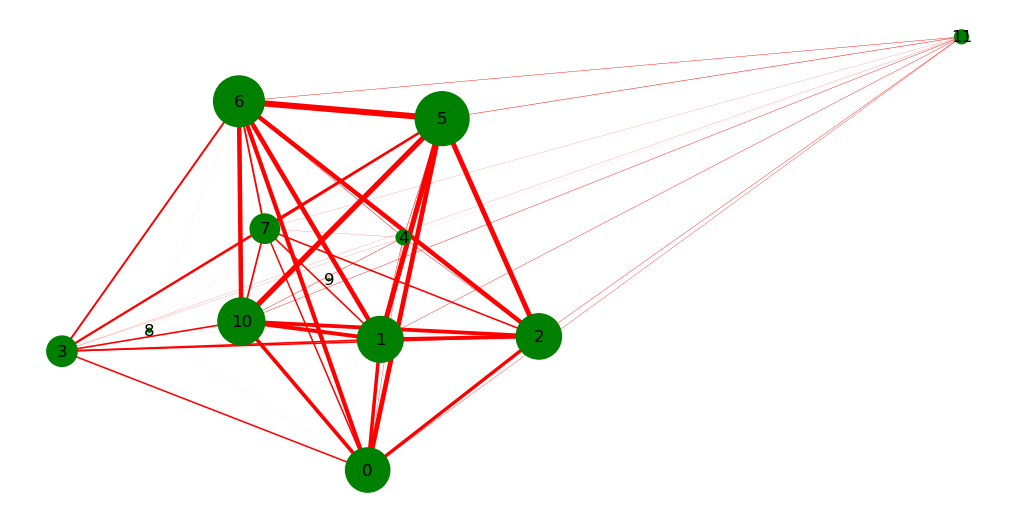

4
{0: 0.9218934911242603, 1: 0.005917159763313609, 2: 0.8994082840236687, 3: 0.028402366863905324, 4: 0.01893491124260355, 5: 0.6887573964497041, 6: 0.01775147928994083, 7: 0.011834319526627219, 8: 0.7266272189349112, 9: 0.0035502958579881655, 10: 0.008284023668639054, 11: 0.6449704142011834}
845


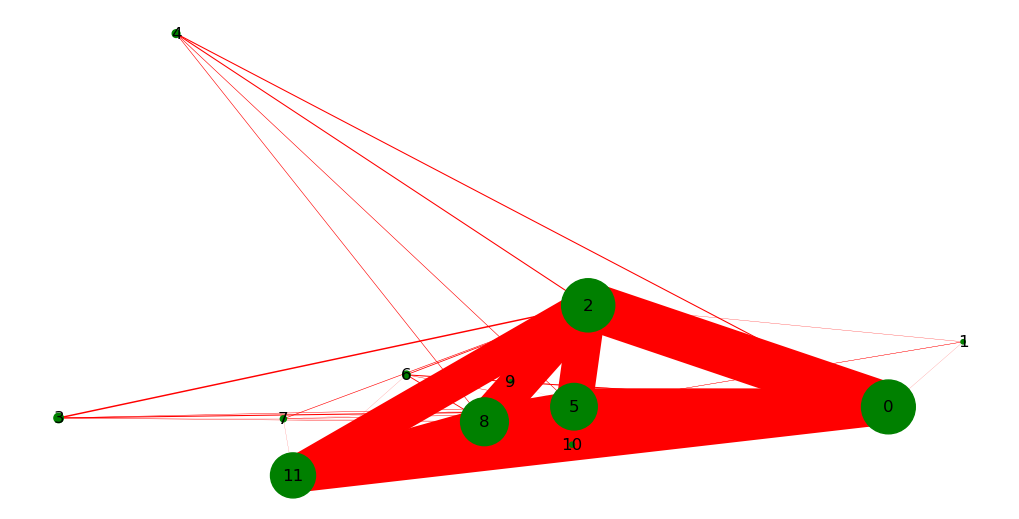

5
{0: 0.00904977375565611, 1: 0.0, 2: 0.013574660633484163, 3: 0.00904977375565611, 4: 0.013574660633484163, 5: 0.9909502262443439, 6: 0.0, 7: 0.004524886877828055, 8: 0.00904977375565611, 9: 0.9773755656108597, 10: 0.00904977375565611, 11: 0.00904977375565611}
221


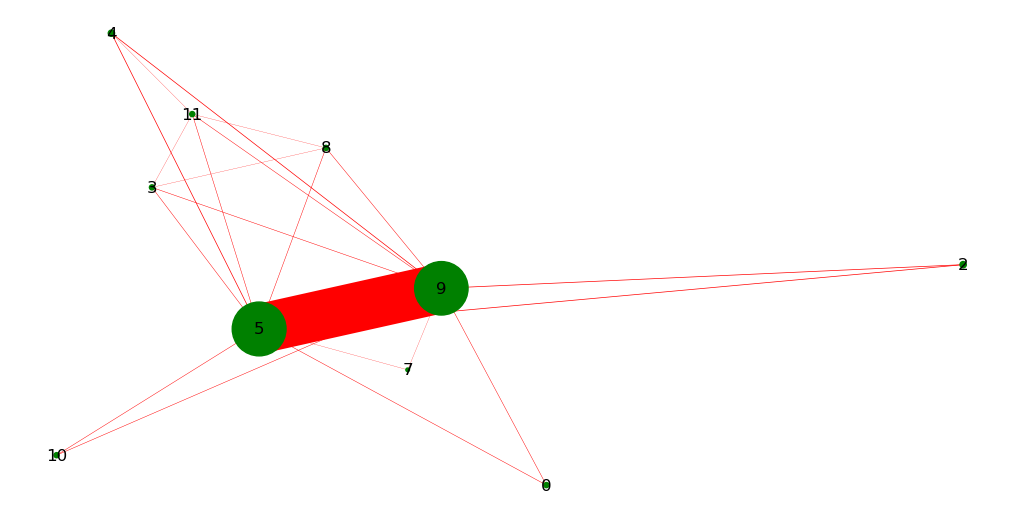

6
{0: 0.014705882352941176, 1: 0.02022058823529412, 2: 0.8400735294117647, 3: 0.9522058823529411, 4: 0.009191176470588236, 5: 0.07720588235294118, 6: 0.7683823529411765, 7: 0.0055147058823529415, 8: 0.9724264705882353, 9: 0.0055147058823529415, 10: 0.1875, 11: 0.001838235294117647}
544


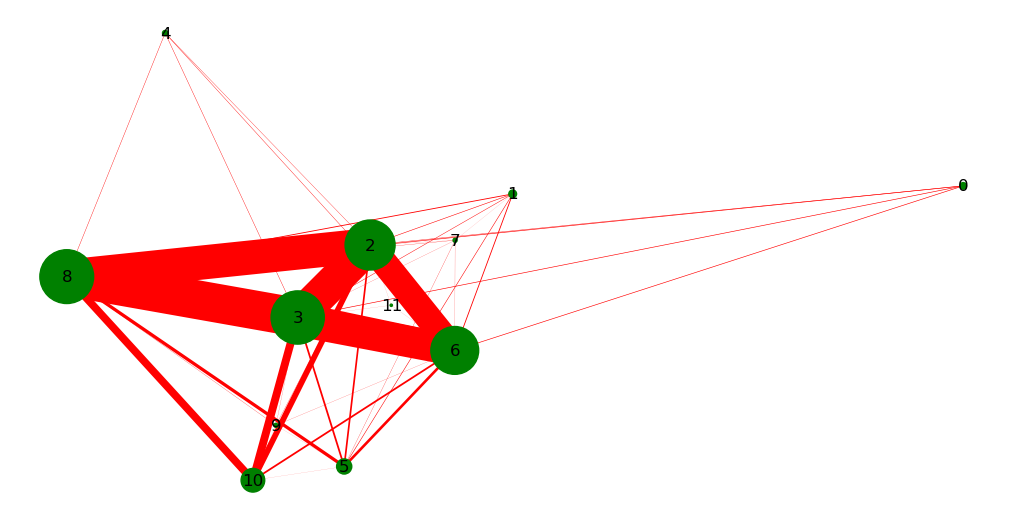

7
{0: 0.24289405684754523, 1: 0.14082687338501293, 2: 0.18992248062015504, 3: 0.7351421188630491, 4: 0.7454780361757106, 5: 0.14728682170542637, 6: 0.04392764857881137, 7: 0.24031007751937986, 8: 0.011627906976744186, 9: 0.9974160206718347, 10: 0.30749354005167956, 11: 0.023255813953488372}
774


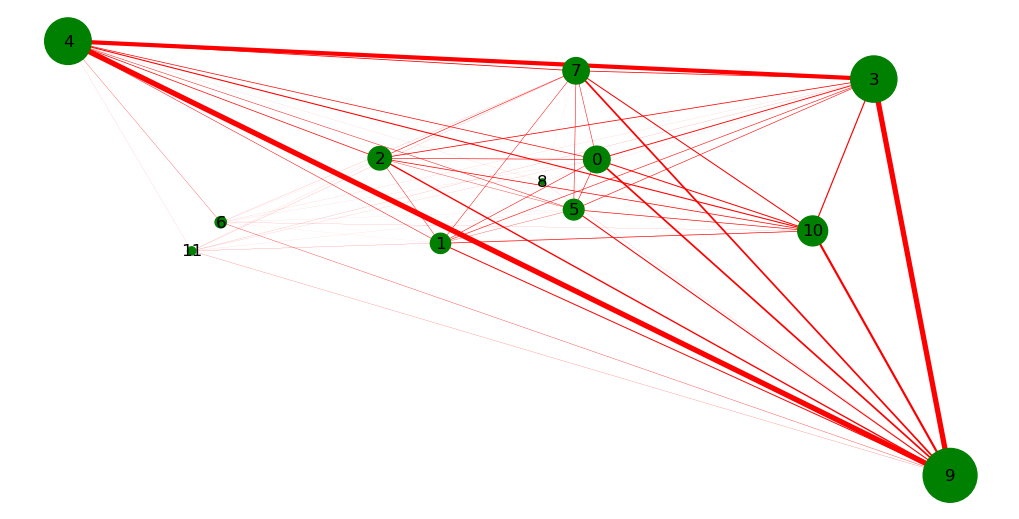

8
{0: 0.6970082749840866, 1: 0.7084659452577976, 2: 0.14385741565881605, 3: 0.21705919796308085, 4: 0.9153405474220242, 5: 0.7542966263526416, 6: 0.24124761298535966, 7: 0.41756842775302355, 8: 0.6791852323360916, 9: 0.02864417568427753, 10: 0.007001909611712286, 11: 0.14894971355824316}
1571


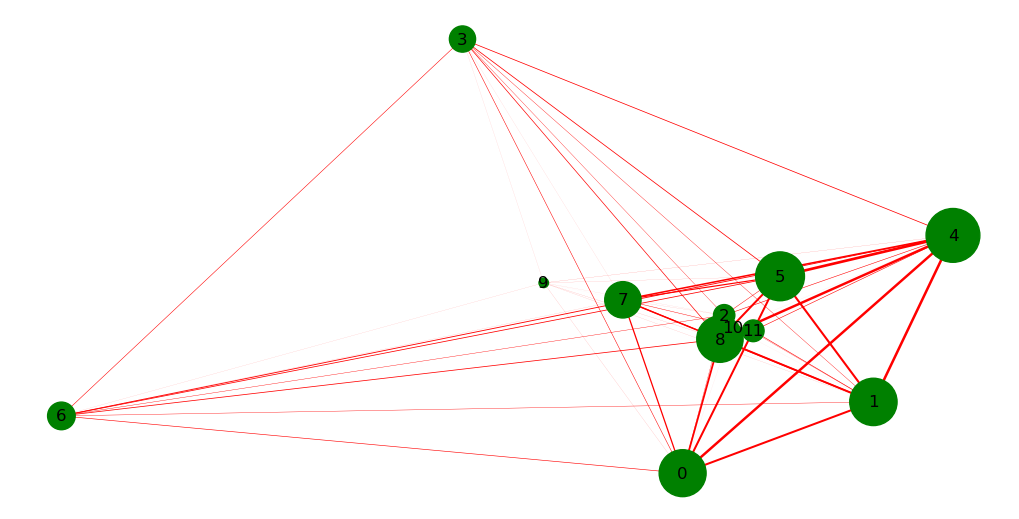

9
{0: 0.9983844911147012, 1: 0.6494345718901454, 2: 0.16962843295638125, 3: 0.9337641357027464, 4: 0.8594507269789984, 5: 0.1583198707592892, 6: 0.012924071082390954, 7: 0.9337641357027464, 8: 0.01615508885298869, 9: 0.38126009693053314, 10: 0.284329563812601, 11: 0.024232633279483037}
619


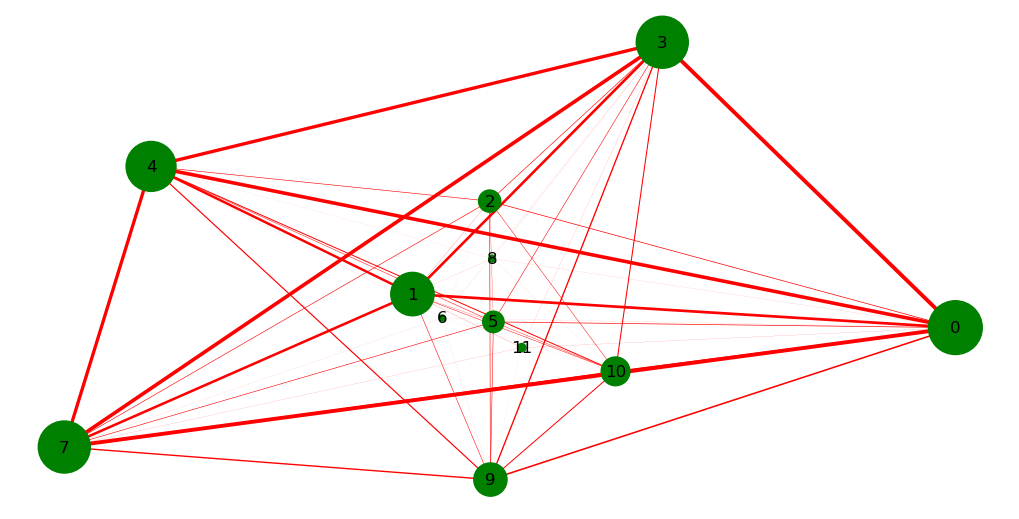

10
{0: 0.35571687840290384, 1: 0.6860254083484574, 2: 0.8330308529945554, 3: 0.13430127041742287, 4: 0.038112522686025406, 5: 0.034482758620689655, 6: 0.4029038112522686, 7: 0.12885662431941924, 8: 0.019963702359346643, 9: 0.023593466424682397, 10: 0.33030852994555354, 11: 0.05989110707803993}
551


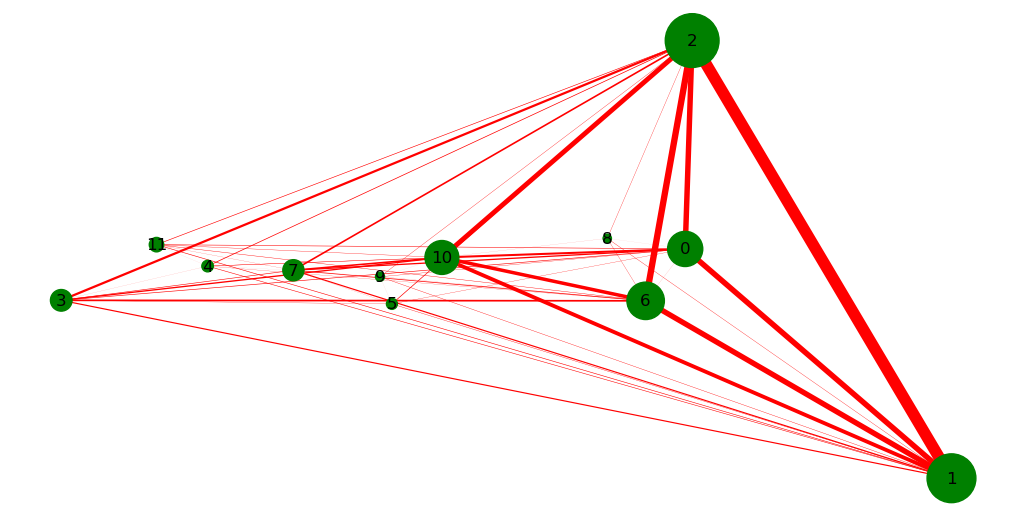

11
{0: 0.9949238578680203, 1: 0.8972081218274112, 2: 0.8984771573604061, 3: 0.0532994923857868, 4: 0.02284263959390863, 5: 0.0, 6: 1.0, 7: 0.06091370558375635, 8: 0.006345177664974619, 9: 0.0025380710659898475, 10: 0.1802030456852792, 11: 0.01649746192893401}
788


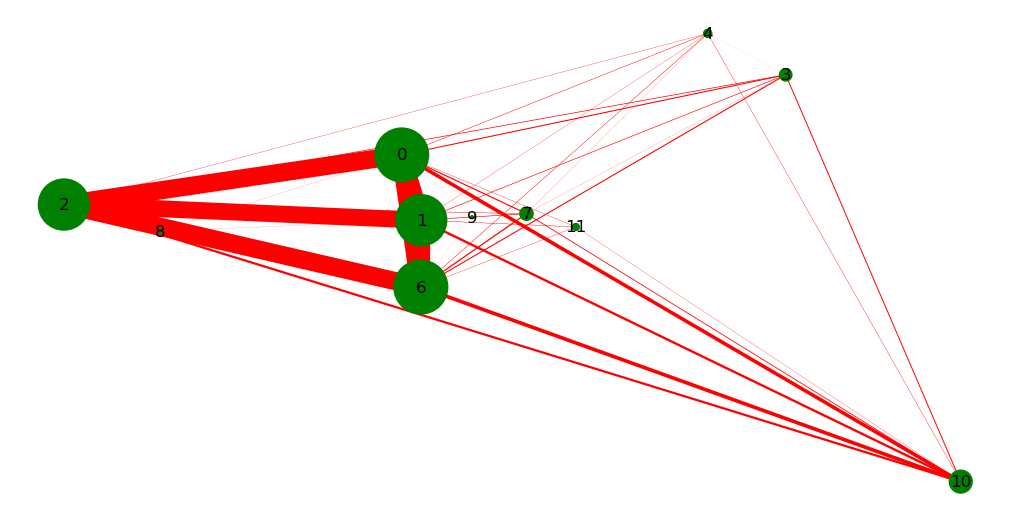

In [56]:
clusters = [data[k.labels_ == i] for i in range(n_clusters)]
# clusters = old_clusters
for see_cluster in range(n_clusters):
    print(see_cluster)
    print({i:x for i,x in enumerate(np.mean(clusters[see_cluster],0))})
    print(len(clusters[see_cluster]))
    cluster_0 = Counter([tuple(np.where(x == 1)[0]) for x in clusters[see_cluster]])

    edge_dict = {}
    for key,value in cluster_0.items():
        for perm in permutations(key, 2):
            try:
                edge_dict[(perm[0], perm[1])] += value
            except KeyError:
                try: 
                    edge_dict[(perm[1], perm[0])] += value
                except KeyError:
                    edge_dict[(perm[0], perm[1])] = value

    edge_list = [(*key, {'weight':value}) for key,value in edge_dict.items()]
    
    G = nx.Graph()
    G.add_nodes_from(sorted(set([y for x in cluster_0.keys() for y in x])))
    G.add_edges_from(edge_list)
    rcParams['figure.figsize'] = 10, 5
    rcParams['figure.dpi'] = 100
    options = {
        'node_color': 'g',
        'edge_color':'r'
    }
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights /= np.median(weights)*3
    
    nodes = G.nodes()
    s = np.sum(clusters[see_cluster],0)
    s /= max(s)
    s *= 1500
    node_size = [s[n] for n in nodes]

    nx.draw_kamada_kawai(G, node_size=node_size, with_labels=True, edgelist=edges, width=weights, **options)
    plt.show()
